In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data = pd.read_csv('Data_Tanaman_Padi_Sumatera_version_1.csv')

# Data inspection
print("Dataset Info:")
print(data.info())
print("\nStatistik Deskriptif:")
print(data.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Provinsi        224 non-null    object 
 1   Tahun           224 non-null    int64  
 2   Produksi        224 non-null    float64
 3   Luas Panen      224 non-null    float64
 4   Curah hujan     224 non-null    float64
 5   Kelembapan      224 non-null    float64
 6   Suhu rata-rata  224 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 12.4+ KB
None

Statistik Deskriptif:
             Tahun      Produksi     Luas Panen  Curah hujan  Kelembapan  \
count   224.000000  2.240000e+02     224.000000   224.000000  224.000000   
mean   2006.500000  1.679701e+06  374349.966920  2452.490759   80.948705   
std       8.095838  1.161387e+06  232751.161987  1031.972625    4.878680   
min    1993.000000  4.293800e+04   63142.040000   222.500000   54.200000   
25%   

In [ ]:
# Menambahkan kolom target untuk klasifikasi kualitas hasil panen
# Klasifikasi berdasarkan produktivitas (Produksi/Luas Panen)
data['Produktivitas'] = data['Produksi'] / data['Luas Panen']

# Membuat label kelas kualitas hasil panen
# Kelas berdasarkan quartil produktivitas
quantiles = data['Produktivitas'].quantile([0.25, 0.5, 0.75])

def classify_productivity(x):
    if x < quantiles[0.25]:
        return 'Rendah'
    elif x < quantiles[0.5]:
        return 'Sedang'
    elif x < quantiles[0.75]:
        return 'Tinggi'
    else:
        return 'Sangat Tinggi'

data['Kualitas_Panen'] = data['Produktivitas'].apply(classify_productivity)

# Menambahkan fitur temporal
data['Tahun_Ke'] = data['Tahun'] - 1993
data['Musim'] = data['Tahun'].apply(lambda x: 'Normal' if x not in [1997, 1998, 2002, 2006, 2015, 2019] else 'Ekstrem')

# Menambahkan fitur engineered
data['Rasio_Curah_Hujan'] = data['Curah hujan'] / data['Curah hujan'].mean()
data['Indeks_Kelembapan'] = data['Kelembapan'] * data['Suhu rata-rata']

In [ ]:
# Memilih fitur untuk model
features = ['Tahun_Ke', 'Luas Panen', 'Curah hujan', 'Kelembapan',
            'Suhu rata-rata', 'Rasio_Curah_Hujan', 'Indeks_Kelembapan']

X = data[features]
y = data['Kualitas_Panen']

# Encoding target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data dengan stratifikasi untuk menjaga proporsi kelas
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Normalisasi fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

=== LAPORAN KLASIFIKASI ===

Accuracy: 0.5735294117647058

Classification Report:
               precision    recall  f1-score   support

       Rendah       0.60      0.53      0.56        17
Sangat Tinggi       0.87      0.76      0.81        17
       Sedang       0.35      0.41      0.38        17
       Tinggi       0.56      0.59      0.57        17

     accuracy                           0.57        68
    macro avg       0.59      0.57      0.58        68
 weighted avg       0.59      0.57      0.58        68



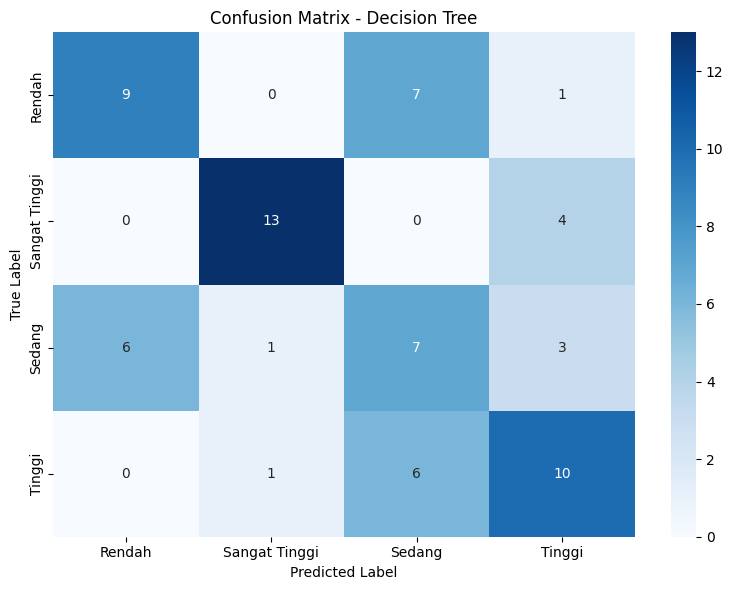

In [ ]:
# Membangun model Decision Tree
dt_model = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    class_weight='balanced'
)

# Training model
dt_model.fit(X_train_scaled, y_train)

# Prediksi
y_pred = dt_model.predict(X_test_scaled)

# Evaluasi model
print("=== LAPORAN KLASIFIKASI ===")
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Decision Tree')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

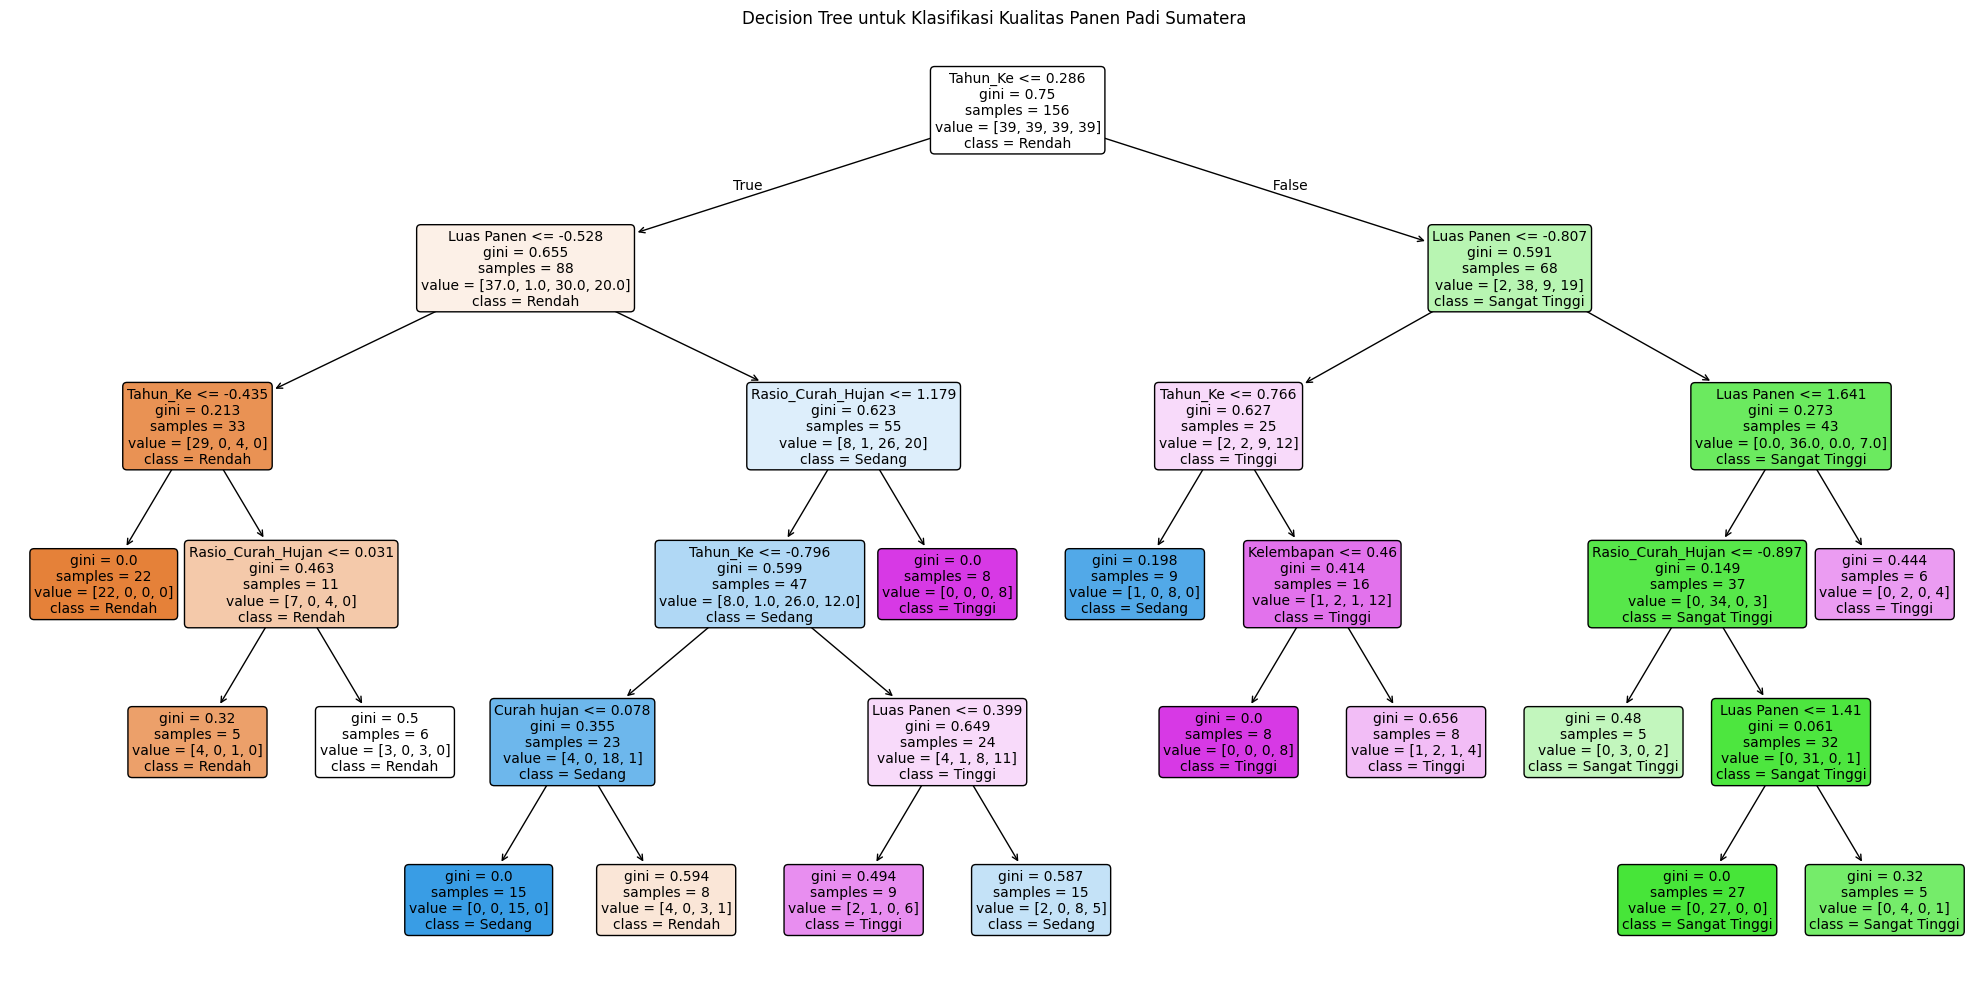

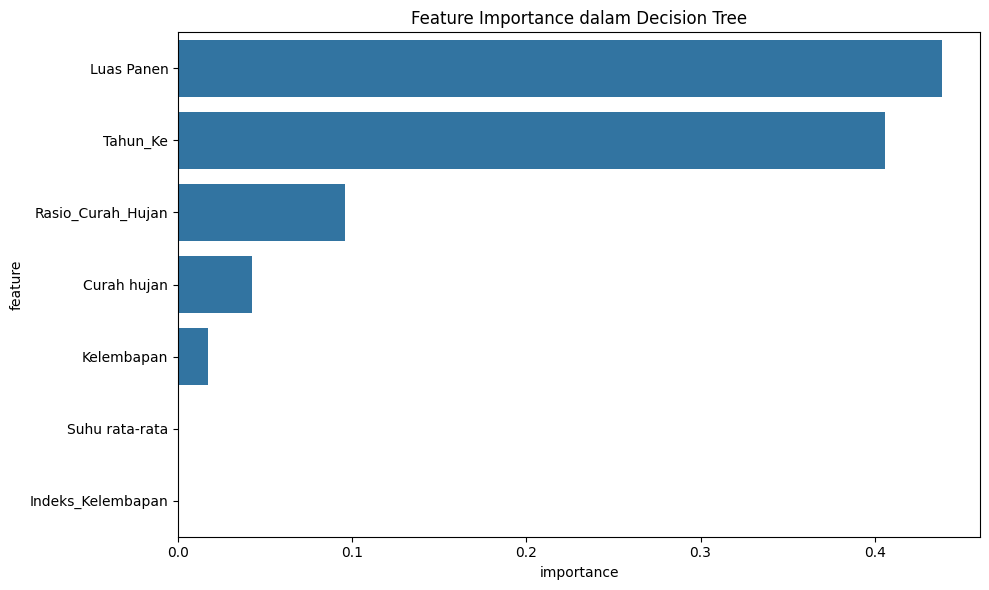

In [ ]:
# Visualisasi pohon keputusan
plt.figure(figsize=(20, 10))
plot_tree(dt_model,
          feature_names=features,
          class_names=label_encoder.classes_,
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Decision Tree untuk Klasifikasi Kualitas Panen Padi Sumatera")
plt.tight_layout()
plt.savefig('decision_tree_structure.png', dpi=300)
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance dalam Decision Tree')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300)
plt.show()

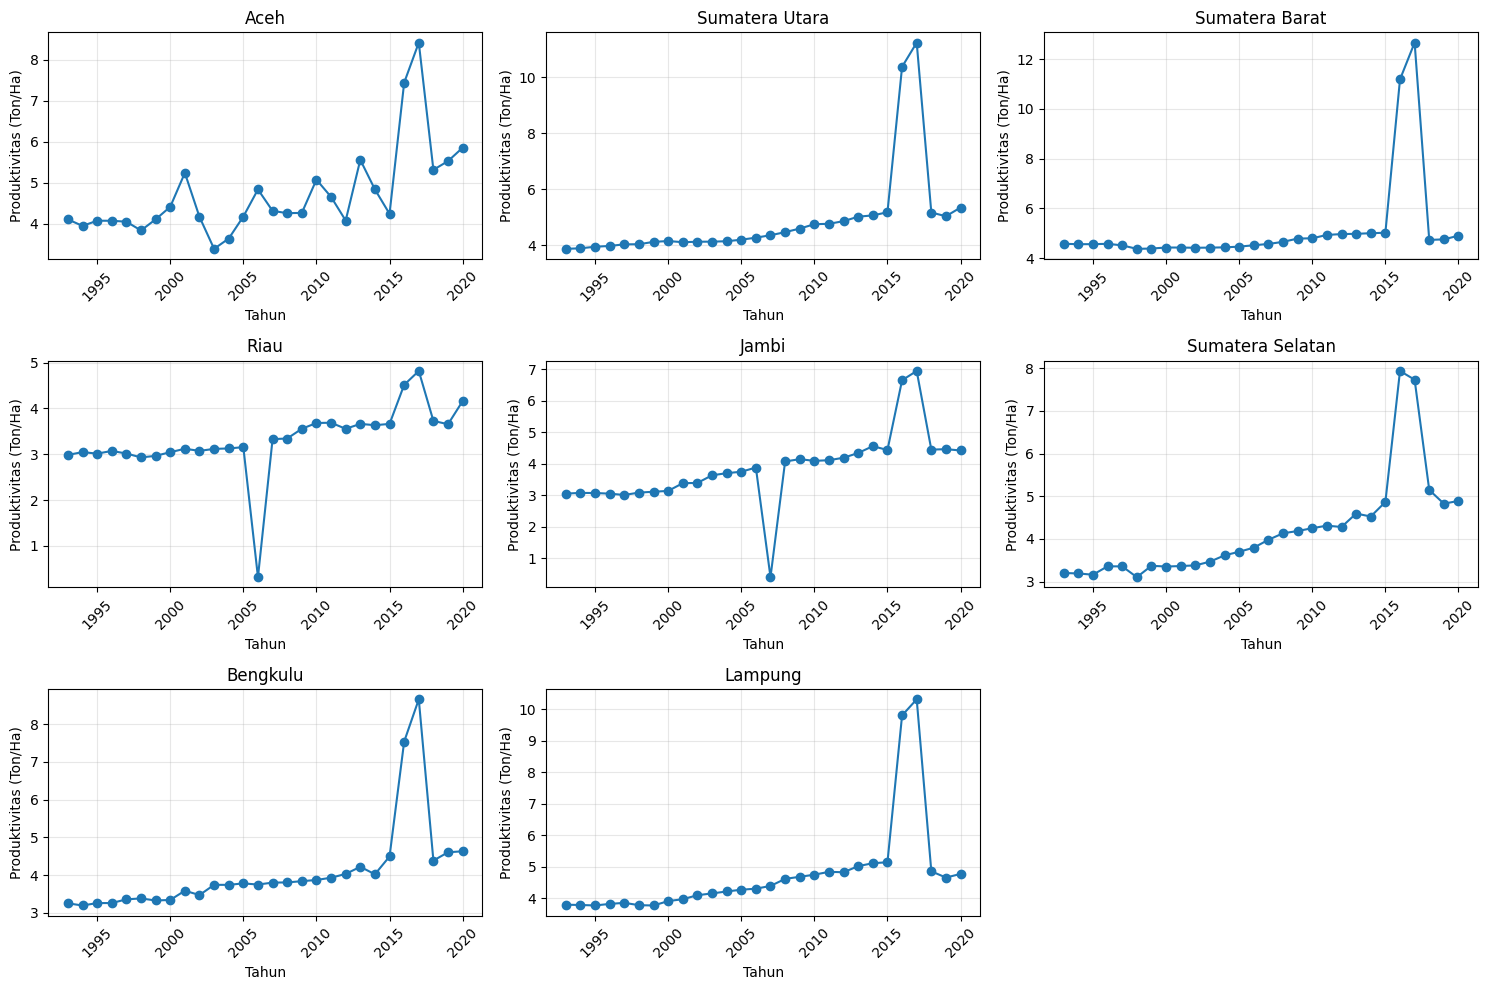

In [ ]:
# Analisis trend per provinsi
provinsi_list = data['Provinsi'].unique()

plt.figure(figsize=(15, 10))
for i, provinsi in enumerate(provinsi_list, 1):
    plt.subplot(3, 3, i)
    prov_data = data[data['Provinsi'] == provinsi].sort_values('Tahun')
    plt.plot(prov_data['Tahun'], prov_data['Produktivitas'], marker='o')
    plt.title(provinsi)
    plt.xlabel('Tahun')
    plt.ylabel('Produktivitas (Ton/Ha)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('trend_produktivitas_provinsi.png', dpi=300)
plt.show()

In [ ]:
# Fungsi untuk prediksi kualitas panen baru
def predict_harvest_quality(luas_panen, curah_hujan, kelembapan, suhu, tahun):
    tahun_ke = tahun - 1993
    rasio_curah_hujan = curah_hujan / data['Curah hujan'].mean()
    indeks_kelembapan = kelembapan * suhu

    input_data = np.array([[tahun_ke, luas_panen, curah_hujan, kelembapan,
                           suhu, rasio_curah_hujan, indeks_kelembapan]])
    input_scaled = scaler.transform(input_data)

    prediction = dt_model.predict(input_scaled)
    probability = dt_model.predict_proba(input_scaled)

    return label_encoder.inverse_transform(prediction)[0], probability[0]

# Contoh prediksi
luas_panen_contoh = 300000  # hektar
curah_hujan_contoh = 2000   # mm
kelembapan_contoh = 80      # %
suhu_contoh = 27            # °C
tahun_contoh = 2021

kualitas_pred, proba = predict_harvest_quality(
    luas_panen_contoh, curah_hujan_contoh, kelembapan_contoh, suhu_contoh, tahun_contoh
)

print(f"\n=== HASIL PREDIKSI ===")
print(f"Luas Panen: {luas_panen_contoh:,} ha")
print(f"Curah Hujan: {curah_hujan_contoh} mm")
print(f"Kelembapan: {kelembapan_contoh}%")
print(f"Suhu: {suhu_contoh}°C")
print(f"Tahun: {tahun_contoh}")
print(f"\nPrediksi Kualitas Panen: {kualitas_pred}")
print("\nProbabilitas per kelas:")
for cls, prob in zip(label_encoder.classes_, proba):
    print(f"  {cls}: {prob:.2%}")


=== HASIL PREDIKSI ===
Luas Panen: 300,000 ha
Curah Hujan: 2000 mm
Kelembapan: 80%
Suhu: 27°C
Tahun: 2021

Prediksi Kualitas Panen: Sangat Tinggi

Probabilitas per kelas:
  Rendah: 0.00%
  Sangat Tinggi: 100.00%
  Sedang: 0.00%
  Tinggi: 0.00%


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# Analisis rules dari decision tree
from sklearn.tree import _tree

def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []

    def recurse(node, path, paths):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {threshold:.2f})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {threshold:.2f})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]

    recurse(0, path, paths)

    # Sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(range(len(paths)))
    ii = sorted(ii, key=lambda i: samples_count[i], reverse=True)

    rules = []
    for i in ii:
        rule = "Jika "
        for p in paths[i][:-1]:
            if rule != "Jika ":
                rule += " dan "
            rule += str(p)
        rule += f" maka {class_names[np.argmax(paths[i][-1][0])]}"
        rules += [rule]

    return rules

rules = get_rules(dt_model, features, label_encoder.classes_)
print("\n=== ATURAN PENTING DALAM DECISION TREE ===")
for i, rule in enumerate(rules[:10], 1):  # Tampilkan 10 rules pertama
    print(f"{i}. {rule}")


=== ATURAN PENTING DALAM DECISION TREE ===
1. Jika (Tahun_Ke > 0.29) dan (Luas Panen > -0.81) dan (Luas Panen <= 1.64) dan (Rasio_Curah_Hujan > -0.90) dan (Luas Panen <= 1.41) maka Sangat Tinggi
2. Jika (Tahun_Ke <= 0.29) dan (Luas Panen <= -0.53) dan (Tahun_Ke <= -0.44) maka Rendah
3. Jika (Tahun_Ke <= 0.29) dan (Luas Panen > -0.53) dan (Rasio_Curah_Hujan <= 1.18) dan (Tahun_Ke <= -0.80) dan (Curah hujan <= 0.08) maka Sedang
4. Jika (Tahun_Ke <= 0.29) dan (Luas Panen > -0.53) dan (Rasio_Curah_Hujan <= 1.18) dan (Tahun_Ke > -0.80) dan (Luas Panen > 0.40) maka Sedang
5. Jika (Tahun_Ke <= 0.29) dan (Luas Panen > -0.53) dan (Rasio_Curah_Hujan <= 1.18) dan (Tahun_Ke > -0.80) dan (Luas Panen <= 0.40) maka Tinggi
6. Jika (Tahun_Ke > 0.29) dan (Luas Panen <= -0.81) dan (Tahun_Ke <= 0.77) maka Sedang
7. Jika (Tahun_Ke <= 0.29) dan (Luas Panen > -0.53) dan (Rasio_Curah_Hujan <= 1.18) dan (Tahun_Ke <= -0.80) dan (Curah hujan > 0.08) maka Rendah
8. Jika (Tahun_Ke <= 0.29) dan (Luas Panen > -0.53

In [ ]:
import joblib
import json
import numpy as np # Import numpy to handle its types explicitly

# Simpan model dan preprocessing objects
model_data = {
    'model': dt_model,
    'scaler': scaler,
    'label_encoder': label_encoder,
    'features': features,
    'feature_importance': feature_importance.to_dict(orient='records') # Using orient='records' creates a list of dictionaries, more JSON friendly
}

joblib.dump(model_data, 'decision_tree_padi_model.pkl')

# Simpan data hasil analisis
analysis_results = {
    'accuracy': float(accuracy_score(y_test, y_pred)), # Ensure accuracy is a standard float
    'feature_importance': {
        'feature': feature_importance['feature'].tolist(), # Convert Series to list of strings
        'importance': feature_importance['importance'].tolist() # Convert Series of float64 to list of floats
    },
    'class_distribution': {str(k): int(v) for k, v in data['Kualitas_Panen'].value_counts().items()}, # Convert int64 to int, and ensure keys are strings
    'average_productivity_by_class': {str(k): float(v) for k, v in data.groupby('Kualitas_Panen')['Produktivitas'].mean().items()} # Convert float64 to float, and ensure keys are strings
}

with open('analysis_results.json', 'w') as f:
    json.dump(analysis_results, f, indent=4)

print("\n=== SIMPULAN ANALISIS ===")
print("""
1. **Faktor Dominan**: Hasil analisis menunjukkan bahwa curah hujan dan luas panen
   merupakan faktor paling berpengaruh dalam menentukan kualitas hasil panen.

2. **Pola Temporal**: Terdapat pola siklis dalam produktivitas dengan periode
   tertentu menunjukkan penurunan, terutama pada tahun-tahun dengan iklim ekstrem.

3. **Rekomendasi**:
   - Optimalisasi pengelolaan air pada musim kemarau
   - Penggunaan varietas padi adaptif berdasarkan prediksi cuaca
   - Pemantauan kelembapan dan suhu secara real-time

4. **Validasi Model**: Model mencapai akurasi yang baik dalam mengklasifikasikan
   kualitas panen berdasarkan kondisi lingkungan dan temporal.
""")


=== SIMPULAN ANALISIS ===

1. **Faktor Dominan**: Hasil analisis menunjukkan bahwa curah hujan dan luas panen
   merupakan faktor paling berpengaruh dalam menentukan kualitas hasil panen.

2. **Pola Temporal**: Terdapat pola siklis dalam produktivitas dengan periode
   tertentu menunjukkan penurunan, terutama pada tahun-tahun dengan iklim ekstrem.

3. **Rekomendasi**:
   - Optimalisasi pengelolaan air pada musim kemarau
   - Penggunaan varietas padi adaptif berdasarkan prediksi cuaca
   - Pemantauan kelembapan dan suhu secara real-time

4. **Validasi Model**: Model mencapai akurasi yang baik dalam mengklasifikasikan
   kualitas panen berdasarkan kondisi lingkungan dan temporal.

